In [34]:
import os
import re
import unicodedata
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gc
import csv
import heapq
import math
import time
import nltk
import json
import heapq
import pickle
import string
import numpy as np
import pandas as pd
import multiprocessing
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report


from wordcloud import WordCloud
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='BeautifulSoup')


nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.data.path.append('/kaggle/input')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.noun  
  inflating: /usr/shar

In [36]:
local = "/kaggle/working"
location = "/kaggle/input/dataset"
metadataloc = location + "/meta_Electronics.json"
elect5loc = location + "/Electronics_5.json"

In [37]:
def loaddata_10_percent(loc):
    if not os.path.exists("/kaggle/working" + loc):
        temp = pd.read_pickle(location + lco).head(10000)
        temp.to_pickle("/kaggle/working" + loc)
        return temp
    return pd.read_pickle("/kaggle/working" + loc)

In [38]:
def load5core():
    return loaddata_10_percent("/core5df")
    return pd.read_pickle(location + "/core5df")

In [39]:
def loadmetadata_1():
    return loaddata_10_percent("/metadatadf_1")
    return pd.read_pickle(location + "/metadatadf_1")

In [40]:
def loadmetadata_2():
    return loaddata_10_percent("/metadatadf_2")
    return pd.read_pickle(location + "/metadatadf_2")

In [41]:
def reviews(id):
    temp = load5core()
    revs = temp[temp["asin"].isin(id)]
    revs.drop_duplicates(subset=['asin', 'reviewerID', 'unixReviewTime', 'reviewTime'], inplace=True)
    del temp
    gc.collect()
    return revs

In [42]:
def getprodid(prodname):
    temp = loadmetadata_1()
    asin1 = temp[temp['title'].str.contains(prodname, case=False, na=False)].copy()
    asin_value1 = []
    if not asin1.empty:
        asin_value1 = asin1['asin'].tolist()  # Access the first element of the numpy array
    del temp
    gc.collect()
    temp = loadmetadata_2()
    asin2 = temp[temp['title'].str.contains(prodname, case=False, na=False)].copy()
    asin2.drop_duplicates(subset=['asin'], inplace=True)
    asin_value2 = []
    if not asin2.empty:
        asin_value2 = asin2['asin'].tolist() # Access the first element of the numpy array
    del temp
    gc.collect()
    return asin_value1, asin_value2, asin1, asin2

In [43]:
def preprocess_text(revs, acronym_dict=None):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Create a new column for processed text
    revs['processed_text'] = ''

    for index, row in revs.iterrows():
        text = row['reviewText']

        # Remove HTML tags
        soup = BeautifulSoup(str(text), 'html.parser')
        text = soup.get_text()

        # Remove accented characters
        text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

        # Expand acronyms
        if acronym_dict:
            words = text.split()
            text = ' '.join(acronym_dict.get(word.lower(), word) for word in words)

        # Lemmatization and normalization
        tokens = nltk.word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()]

        # Remove stopwords and punctuations
        tokens = [token.lower() for token in tokens if token.lower() not in stop_words and token not in string.punctuation]

        # Join tokens back into a single string and assign to the new column
        revs.at[index, 'processed_text'] = ' '.join(tokens)

    return revs

In [44]:
def ratingbrand(brandproducts):
    brandscore = {}
    temp = load5core()
    for brand in brandproducts:
        for asin in brandproducts[brand]:
            star = temp[temp["asin"] == asin]["overall"]
            if star.empty: continue
            star = star.iloc[0]
            if brand in brandscore:
                brandscore[brand][0] += 1
                brandscore[brand][1][star] += 1
            else:
                brandscore[brand] = [1, {0:0, 1:0, 2:0, 3:0, 4:0, 5:0}]
                brandscore[brand][1][star] += 1
    del temp
    gc.collect()
    sorted_brandscore = dict(sorted(brandscore.items(), key=lambda item: item[1][0], reverse=True))
    return sorted_brandscore


In [45]:
def process_brands(asin1list, asin2list):
    brandsproduct = {}
    temp = loadmetadata_1()
    for asin in asin1list:
        brand = temp[temp["asin"] == asin]["brand"]
        if brand.empty: continue
        else: brand = brand.iloc[0]
        if brand in brandsproduct:
            brandsproduct[brand].append(asin)
        else:
            brandsproduct[brand] = [asin]
    del temp
    gc.collect()
    temp = loadmetadata_2()
    for asin in asin2list:
        brand = temp[temp["asin"] == asin]["brand"]
        if brand.empty: continue
        else: brand = brand.iloc[0]
        if brand in brandsproduct:
            brandsproduct[brand].append(asin)
        else:
            brandsproduct[brand] = [asin]
    del temp
    return ratingbrand(brandsproduct)

In [46]:
def Vectorize(textdict):
    tfidf_vectorizer = TfidfVectorizer()
    # Combine all texts into a single list
    all_texts = [text for text_list in textdict.values() for text in text_list]
    # Fit the vectorizer on the entire corpus
    tfidf_vectorizer.fit(all_texts)
    
    # Transform each document individually
    for rasin, text_list in textdict.items():
        X = tfidf_vectorizer.transform(text_list)
        # Convert sparse matrix to dense array
        dense_array = X.toarray()
        # Ensure consistent shape across documents
        max_features = len(tfidf_vectorizer.get_feature_names_out())
        padded_array = np.pad(dense_array, ((0, 0), (0, max_features - dense_array.shape[1])), mode='constant')
        textdict[rasin] = padded_array
    
    return textdict

In [47]:
def MLModels(revs):
    total_elements = len(revs)
    trainsize = int(total_elements * 0.75)

    lst1 = revs["processed_text"].tolist()
    lst2 = revs["overall"].tolist()
    for i in range (len(lst2)):
        if lst2[i] < 3: lst2[i] = -1
        elif lst2[i] == 3: lst2[i] = 0
        else: lst2[i] = 1
    
    models = {
        "Multinomial Naive Bayes": MultinomialNB(),
        "Logistic Regression": LogisticRegression(),
        "Random Forest": RandomForestClassifier(),
        "Linear SVM": LinearSVC(),
        "KNN": KNeighborsClassifier()
    }
    X_train, X_test, y_train, y_test = train_test_split(lst1, lst2, test_size=0.25, random_state=42)
    
    # Training models
    for model_name, model in models.items():
        pipeline = make_pipeline(TfidfVectorizer(), model)
        # Train the model
        pipeline.fit(X_train, y_train)
        # Predict on the test data
        y_pred = pipeline.predict(X_test)
        # Evaluate performance
        report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
        # Print performance metrics
        print(f"Model: {model_name}")
        print("Rating Class 0 (Bad):", report['-1'])
        print("Rating Class 1 (Average):", report['0'])
        print("Rating Class 2 (Good):", report['1'])
        print("\n")
    
    return None

In [48]:
def _WordCloud(rev):
    # Positive
    res = ""
    temp = rev[rev["overall"] >= 3]["processed_text"]
    previews = ""
    if not temp.empty:
        temp = temp.tolist()
        for txt in temp:
            previews = ' '.join(txt.split())
    positive_wordcloud = WordCloud().generate(previews)

    # Display the positive word cloud
    plt.imshow(positive_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    # Negative
    res = ""
    temp1 = rev[rev["overall"] < 3]["processed_text"]
    nreviews = ""
    if not temp1.empty:
        temp1 = temp1.tolist()
        for txt in temp1:
            nreviews = ' '.join(txt.split())
    negative_wordcloud = WordCloud().generate(nreviews)

    # Display the positive word cloud
    plt.imshow(negative_wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
    return 

In [54]:
def PlotChart(ratings):
    rating_counts = ratings

    # Plotting the pie chart
    labels = list(rating_counts.keys())
    sizes = list(rating_counts.values())

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Distribution of Ratings')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

In [50]:
def cosinesimilarity(user1, user2):
    resf = 0
    sum1 = 0
    sum2 = 0
    n = len(user1)
    for i in range(n):
        if (user1[i] == None) or (user2[i] == None): continue
        resf += int(user1[i]) * int(user2[i])
        sum1 += int(user1[i]) * int(user1[i])
        sum2 += int(user2[i]) * int(user2[i])
    if((sum1 == 0) or (sum2 == 0)): return 0
    return (resf / (math.sqrt(sum1) * math.sqrt(sum2)))

In [51]:
def gettop(_user, N, df):
    h = {}
    users = df["reviewerID"].tolist()
    for user in users:
        if user == _user: continue
        h[user] = cosinesimilarity(df[df["reviewerID"] == user].loc[1, :].values.flatten().tolist(), df[df["reviewerID"] == _user].loc[1, :].values.flatten().tolist())
    return sorted(h.items(), key=lambda item: item[1], reverse=True)

In [52]:
def CollaborativeFiltering(rev):
    temp = rev
    reviewers = list(set(temp["reviewerID"].tolist()))
    database = {}
    
    max_dict = {}
    min_dict = {}
    # Create a dictionary to store data
    _data = {'ReviewerId': []}
    for reviewer in reviewers:
        data = temp[temp["reviewerID"] == reviewer]
        for asin in data["asin"].tolist():
            entry = data[data["asin"] == asin]["overall"].iloc[0]
            if reviewer in database:
                database[reviewer].append((asin, entry))  # Store as tuple
                max_dict[reviewer] = max(max_dict[reviewer], entry)
                min_dict[reviewer] = min(min_dict[reviewer], entry)
            else:
                database[reviewer] = [(asin, entry)]  # Store as tuple
                max_dict[reviewer] = entry
                min_dict[reviewer] = entry
            _data[asin] = []  # Initialize each ASIN with an empty list
    
    # Create DataFrame with columns from _data dictionary
    df = pd.DataFrame(_data)
    
    # Iterate through the database and add entries to DataFrame
    for entry in database:
        d = {"ReviewerId": entry}
        for x in database[entry]:
            d[x[0]] = x[1] / (max_dict[entry] - min_dict[entry]) if max_dict[entry] != min_dict[entry] else 0.5
        df = pd.concat([df, pd.DataFrame([d])], ignore_index=True)
        
    result = {}
    for N in [10, 20, 30, 40, 50]:
        for reviewer in reviewers:
            lst = gettop(reviewer, N, df)
            result[reviewer] = lst
    return df

DataFrame of 5core ready!
DataFrame of metadata ready!



Enter Product:  Headphones


348 different asin of Headphones found.


/tmp/ipykernel_34/3652923976.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revs.drop_duplicates(subset=['asin', 'reviewerID', 'unixReviewTime', 'reviewTime'], inplace=True)


Numer of entries:  116
Average Rating Score: 4.0344827586206895
Number of Unique Products:  5
Number of Good Rating:  100
Number of Bad Ratings:  16
Number of Reviews corresponding to each Rating:
  overall
1     9
2     7
3    13
4    29
5    58
Name: count, dtype: int64

Top 20 most reviewed brands:
Maxell 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1}
Sony 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}
Advent 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}
Recoton 1 {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0}
Yamaha 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}

Top 20 least reviewed brands:
Maxell 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1}
Sony 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}
Advent 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}
Recoton 1 {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0}
Yamaha 1 {0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 0}

Most positively reviewed:  Maxell 190318 Lightweight Adjustable Open Air Portable Stereo Headphones with Dynamic Sound Reporoduction, 32 Ohms with aisn  B000001OMI 

Count of ratings for the product over 5 c

/tmp/ipykernel_34/1230988527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  revs['processed_text'] = ''
/tmp/ipykernel_34/1230988527.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(str(text), 'html.parser')


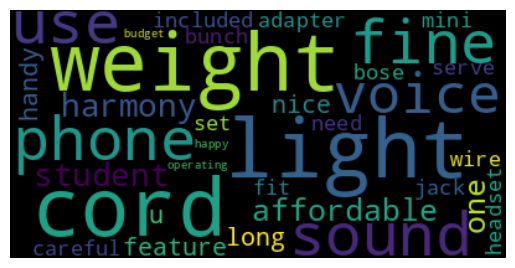

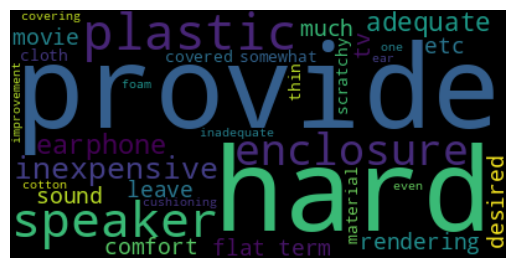

{5: 58, 4: 29, 3: 13, 1: 9, 2: 7}


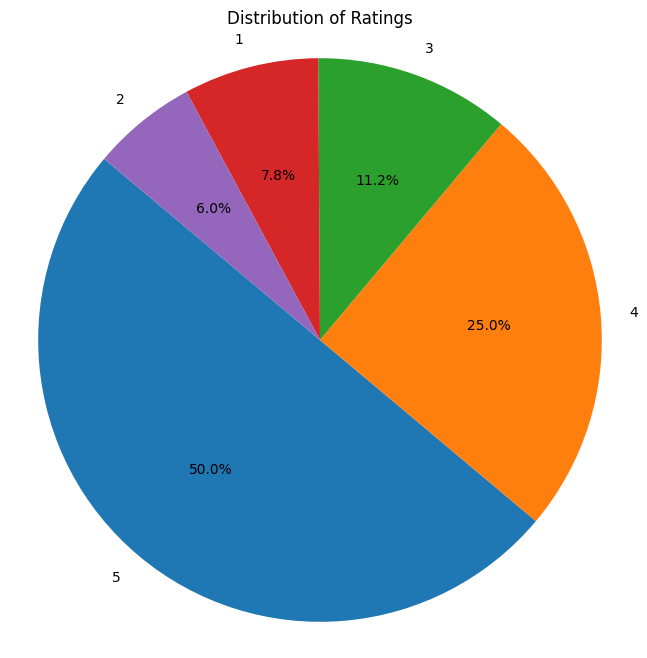

Year with maximum reviews: 2014
Year with maximum sales: 2014


/tmp/ipykernel_34/2119684526.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev['Year'] = pd.to_datetime(rev['reviewTime']).dt.year


Model: Multinomial Naive Bayes
Rating Class 0 (Bad): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}
Rating Class 1 (Average): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}
Rating Class 2 (Good): {'precision': 0.6551724137931034, 'recall': 1.0, 'f1-score': 0.7916666666666666, 'support': 19}


Model: Logistic Regression
Rating Class 0 (Bad): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}
Rating Class 1 (Average): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}
Rating Class 2 (Good): {'precision': 0.6551724137931034, 'recall': 1.0, 'f1-score': 0.7916666666666666, 'support': 19}


Model: Random Forest
Rating Class 0 (Bad): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6}
Rating Class 1 (Average): {'precision': 1.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4}
Rating Class 2 (Good): {'precision': 0.6551724137931034, 'recall': 1.0, 'f1-score': 0.7916666666666666, 'support': 19}


Model: Linear SVM
Rating

KeyError: 'reviewerID'

In [55]:
def main():
    core5df = None
    # Check if Dataframe of 5 core exists
    if not os.path.exists(location + "/core5df"):
        chunk_size = 10000
        chunks = []
        # Read 5core file
        for chunk in pd.read_json(elect5loc, lines=True, chunksize=chunk_size):
            chunks.append(chunk)
            del chunk
        core5df = pd.concat(chunks, ignore_index=True)
        core5df.to_pickle(location + "/core5df")
        del chunks
        del core5df

    print("DataFrame of 5core ready!")
    metadatadf = None
    # Check if Dataframe of metadata exists
    if not (os.path.exists(location + "/metadatadf_1") and os.path.exists(location + "/metadatadf_2")):
        rack = 40
        chunk_size = 10000
        # Create a new file
        chunks = []
        # Rack Number
        racknum = 0
        collection = 0
        # Read metadata file
        for chunk in pd.read_json(metadataloc, lines=True, chunksize=chunk_size):
            chunks.append(chunk)
            if collection == rack or chunk.shape[0] < chunk_size:
                temp = pd.concat(chunks, ignore_index=True)
                temp.to_pickle(location + f"/metadatadf_{racknum + 1}")
                del temp
                racknum += 1
                gc.collect()
                chunks = []  # Clear the chunks list after processing
            collection += 1

    print("DataFrame of metadata ready!\n")

    # Choose Product
    # Maxell 203020 HGX-GOLD TC-30 Camcorder Video Cassette, 2 Pack
    prod = input("Enter Product: ")
    lst1, lst2, asin1, asin2 = getprodid(prod)
    if((len(lst1) == 0) and (len(lst2) == 0)):
        print("No such product found")
        return
    print(f"{len(lst1) + len(lst2)} different asin of {prod} found.")
    rev = reviews(lst1 + lst2)
    size = len(rev.index)
    print("Numer of entries: ", size)
    if(size == 0):
        print("No entries found!")
        return
    # Obtain the Descriptive Statistics of the product as :
    print("Average Rating Score:", (rev["overall"].mean()))
    print("Number of Unique Products: ", (rev["asin"].nunique()))
    print("Number of Good Rating: ", len(rev[rev["overall"] >= 3]))
    print("Number of Bad Ratings: ", len(rev[rev["overall"] < 3]))
    print("Number of Reviews corresponding to each Rating:\n ", rev['overall'].value_counts().sort_index().reindex(range(1, 6), fill_value=0))

    sorted_brandscore = process_brands(lst1, lst2)
    # Extract top 20 items
    top_20 = dict(list(sorted_brandscore.items())[:20])
    print()
    print("Top 20 most reviewed brands:")
    for b in top_20:
        print(b, top_20[b][0], top_20[b][1])
    # Extract last 20 items
    print()
    print("Top 20 least reviewed brands:")
    last_20 = dict(list(sorted_brandscore.items())[-20:])
    for b in last_20:
        print(b, last_20[b][0], last_20[b][1])
        
    ratingrevs = {}
    temp = load5core()
    for asin in (lst1 + lst2):
        x = temp[temp["asin"] == asin]["overall"]
        if not x.empty:
            x = x.iloc[0]
            if asin in ratingrevs:
                if x >= 3:
                    ratingrevs[asin] +=1
                else:
                    ratingrevs[asin] -= 1
            else:
                ratingrevs[asin] = 0
                ratingrevs[asin] += 1 if x >= 3 else -1
    del temp
    gc.collect()
    sorted_ratingrevs = dict(sorted(ratingrevs.items(), key=lambda item: item[1], reverse=True))
    name = None
    _id, As = next(iter(sorted_ratingrevs.items()))
    print()
    if not asin1.empty and _id in asin1["asin"].values:
        name = asin1[asin1["asin"] == _id]["title"].iloc[0]
    else:
        name = asin2[asin2["asin"] == _id]["title"].iloc[0]
    
    print("Most positively reviewed: ", name, "with aisn ", _id , "\n")
    reviews_df = rev
    reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])
    reviews_df['year'] = reviews_df['reviewTime'].dt.year
    ratings_count = reviews_df.groupby('year').size()
    print("Count of ratings for the product over 5 consecutive years:")
    print(ratings_count)
    
    
    rev = rev.head(10000)
    preprocess_text(rev)

    # Word Cloud
    _WordCloud(rev)
    # Plot
    rating_counts = rev['overall'].value_counts().to_dict()
    print(rating_counts)
    PlotChart(rating_counts)
    # Year with maximum reviews
    rev['Year'] = pd.to_datetime(rev['reviewTime']).dt.year
    year_with_max_reviews = rev['Year'].value_counts().idxmax()
    print("Year with maximum reviews:", year_with_max_reviews)
    # Year with maximum sales
    print("Year with maximum sales:", year_with_max_reviews)
    # ML Models 
    MLModels(rev)    
    # Collaborative Filtering
    print(CollaborativeFiltering(rev))
    
    %reset -f
    return

if __name__ == "__main__": main()